In [1]:
%load_ext autoreload
%autoreload 2
import multibind as mb
import numpy as np
import pandas as pd
import torch
import torch.optim as topti
import torch.utils.data as tdata
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../annotations'
import matplotlib.pyplot as plt
import seaborn as sns
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

/home/johanna/anaconda3/envs/multibind/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:
matlab_path = os.path.join(bd.constants.ANNOTATIONS_DIRECTORY, 'pbm', 'affreg', 'PbmDataHom6_norm.mat')
mat = scipy.io.loadmat(matlab_path)
data = mat['PbmData'][0]
seqs_dna =  data[0][5]
seqs_dna = [s[0][0] for s in seqs_dna]
# load the MSA sequences, one hot encoded
df, signal = bd.datasets.PBM.pbm_homeo_affreg()
# x, y = pickle.load(open('../../data/example_homeo_PbmData.pkl', 'rb'))
x, y = pickle.load(open('../annotations/pbm/example_homeo_PbmData.pkl', 'rb'))

In [3]:
# build a small subsample
# x = x[1:6]
seqs_dna = seqs_dna[0:1000]
signal = signal[:, 0:1000]

In [57]:
seqs_dna

['TAGCTTTCCAAAATTCACCAGTAACTTGGTAAATCCGTCTGTGTTCCGTTGTCCGTGCTG',
 'CGCATGCCCGAGCCTAATTGCTTCTTCGTCGTAGTCGTCTGTGTTCCGTTGTCCGTGCTG',
 'GTCTATTTTAAAAACAATACGCACGCCCGTCATATAGTCTGTGTTCCGTTGTCCGTGCTG',
 'CGATTTCCCTCCGTTCTCACACCTAGACGGTTTCCAGTCTGTGTTCCGTTGTCCGTGCTG',
 'AGCTATAAGGACAACGCTTCGCGCGCGCAATCATACGTCTGTGTTCCGTTGTCCGTGCTG',
 'AGATGTCACAGCTAGCGCGTTGGCCCCTCACAATCTGTCTGTGTTCCGTTGTCCGTGCTG',
 'GACTCCTCTAGGGTGTATTGAACCCTCATAACTCAGGTCTGTGTTCCGTTGTCCGTGCTG',
 'AACTACGTCTACCAGACTTTCCAAACCCTTACTGTGGTCTGTGTTCCGTTGTCCGTGCTG',
 'AAACACGCCGTAGTCTACGGTCCCGGAGTTCCCCCCGTCTGTGTTCCGTTGTCCGTGCTG',
 'TGTTTAACGTAAATAGGACCGACCAGGTCATCGCGCGTCTGTGTTCCGTTGTCCGTGCTG',
 'GCACATCGGCATGATATTGTTAATCAGTTATGATAAGTCTGTGTTCCGTTGTCCGTGCTG',
 'TTCCATGGTTACCTACTAGGTAGAGTAACGCCACAAGTCTGTGTTCCGTTGTCCGTGCTG',
 'AAAGCTAGGGCTTTACCTGCATCCGGTTTTTCATGGGTCTGTGTTCCGTTGTCCGTGCTG',
 'AGGCGGGCCTCCATAACGCCGACGTATGACCATGACGTCTGTGTTCCGTTGTCCGTGCTG',
 'TACATCCCTTCAGATGCATCAACATCCTGTTCGCTCGTCTGTGTTCCGTTGTCCGTGCTG',
 'GTTGGCTGGCGATGCTCGATGGA

In [4]:
# shift signal by adding a constant s.t. no negative values are included
signal -= np.min(signal)

In [54]:
# Set up the dataset
df = pd.DataFrame(signal.T)
df['seq'] = seqs_dna
df.index = df['seq']
del df['seq']

dataset = mb.datasets.ResiduePBMDataset(df, x)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

# Set up the model
model = mb.models.ProteinDNABinding(0, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
reconstruction_crit = torch.nn.CrossEntropyLoss()

In [56]:
# no reconstruction criterion
mb.tl.train_network(model, train, device, optimizer, criterion, reconstruction_crit, num_epochs=15, exp_max=-1, log_each=1, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'torch.nn.modules.loss.MSELoss'> n_epochs 15 early_stopping -1
lr= 0.001, weight_decay= 0, dir weight= 0
Epoch:  2, Loss: 2539.271624 , best epoch: 0 secs per epoch: 82.714 s
Epoch:  3, Loss: 811.682493 , best epoch: 1 secs per epoch: 62.162 s
Epoch:  4, Loss: 278.579910 , best epoch: 2 secs per epoch: 55.267 s
Epoch:  5, Loss: 88.819532 , best epoch: 3 secs per epoch: 51.602 s
Epoch:  6, Loss: 23.271246 , best epoch: 4 secs per epoch: 49.571 s
Epoch:  7, Loss: 4.540385 , best epoch: 5 secs per epoch: 48.145 s
Epoch:  8, Loss: 1.103720 , best epoch: 6 secs per epoch: 47.169 s
Epoch:  9, Loss: 0.849620 , best epoch: 7 secs per epoch: 46.472 s
Epoch: 10, Loss: 0.846473 , best epoch: 8 secs per epoch: 45.986 s
Epoch: 11, Loss: 0.846343 , best epoch: 9 secs per epoch: 45.479 s
Epoch: 12, Loss: 0.846327 , best epoch: 10 secs per epoch: 45.217 s
Epoch: 13, Loss: 0.846131 , best epoch: 11 secs per epoch: 44.885 s
Epoch: 14, Loss: 0.8

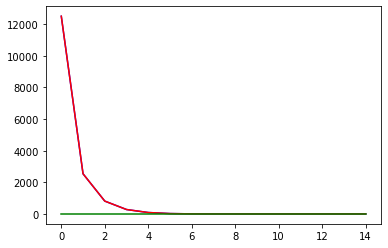

In [57]:
plt.plot(model.loss_history, 'b')
plt.plot(model.crit_history, 'r')
plt.plot(model.rec_history, 'g')

In [58]:
model.rec_history

[18.76495100661716,
 18.764951097116807,
 18.764950836587516,
 18.764950654217017,
 18.76495053217961,
 18.764950748830284,
 18.764950637762535,
 18.764950548634094,
 18.764950828360277,
 18.764950880466134,
 18.764950718663734,
 18.764950656959428,
 18.764951097116807,
 18.764950144128093,
 18.764950581543058]

In [60]:
# Set up the dataset
df = pd.DataFrame(signal.T)
df['seq'] = seqs_dna
df.index = df['seq']
del df['seq']

dataset = mb.datasets.ResiduePBMDataset(df, x)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

# Set up the model
model = mb.models.ProteinDNABinding(0, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
reconstruction_crit = torch.nn.CrossEntropyLoss()

In [61]:
# +0.01*reconstruction criterion
mb.tl.train_network(model, train, device, optimizer, criterion, reconstruction_crit, num_epochs=15, exp_max=-1, log_each=1, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'torch.nn.modules.loss.MSELoss'> n_epochs 15 early_stopping -1
lr= 0.001, weight_decay= 0, dir weight= 0
Epoch:  2, Loss: 1313836097402597.250000 , best epoch: 0 secs per epoch: 79.560 s
Epoch:  3, Loss: 3564787619512602.500000 , best epoch: 0 secs per epoch: 59.846 s
Epoch:  4, Loss: 4549153211778891.000000 , best epoch: 0 secs per epoch: 53.270 s
Epoch:  5, Loss: 2871478146022356.500000 , best epoch: 0 secs per epoch: 49.971 s
Epoch:  6, Loss: 1274861696297447.250000 , best epoch: 0 secs per epoch: 48.125 s
Epoch:  7, Loss: 708253723780822.625000 , best epoch: 0 secs per epoch: 46.853 s
Epoch:  8, Loss: 466471770342828.437500 , best epoch: 0 secs per epoch: 45.940 s
Epoch:  9, Loss: 211576019475061.781250 , best epoch: 0 secs per epoch: 45.191 s
Epoch: 10, Loss: 289890018119129.375000 , best epoch: 0 secs per epoch: 44.611 s
Epoch: 11, Loss: 153236179608785.437500 , best epoch: 0 secs per epoch: 44.175 s
Epoch: 12, Loss: 851

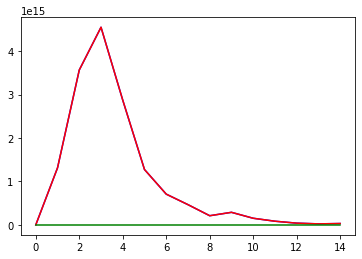

In [62]:
plt.plot(model.loss_history, 'b')
plt.plot(model.crit_history, 'r')
plt.plot(model.rec_history, 'g')

In [63]:
model.rec_history

[10.530189612201442,
 9.245434704142282,
 9.089843544318983,
 9.028562098077353,
 8.998071247514934,
 8.976294695773971,
 8.963559252165103,
 8.941736287817005,
 8.955976794727581,
 8.927427639471036,
 8.923847179289433,
 8.917785076851642,
 8.914482174289903,
 8.925180310400847,
 8.90817016187458]

In [64]:
# Set up the dataset
df = pd.DataFrame(signal.T)
df['seq'] = seqs_dna
df.index = df['seq']
del df['seq']

dataset = mb.datasets.ResiduePBMDataset(df, x)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

# Set up the model
model = mb.models.ProteinDNABinding(0, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
reconstruction_crit = torch.nn.CrossEntropyLoss()

In [65]:
# +0.0001*reconstruction criterion
mb.tl.train_network(model, train, device, optimizer, criterion, reconstruction_crit, num_epochs=15, exp_max=-1, log_each=1, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'torch.nn.modules.loss.MSELoss'> n_epochs 15 early_stopping -1
lr= 0.001, weight_decay= 0, dir weight= 0
Epoch:  2, Loss: 13177283195252.312500 , best epoch: 0 secs per epoch: 79.362 s
Epoch:  3, Loss: 1367688094925995.500000 , best epoch: 0 secs per epoch: 59.683 s
Epoch:  4, Loss: 15400654143550096.000000 , best epoch: 0 secs per epoch: 53.236 s
Epoch:  5, Loss: 39086993530085112.000000 , best epoch: 0 secs per epoch: 49.965 s
Epoch:  6, Loss: 31761217216021540.000000 , best epoch: 0 secs per epoch: 48.051 s
Epoch:  7, Loss: 28185975007020232.000000 , best epoch: 0 secs per epoch: 46.826 s
Epoch:  8, Loss: 24124343444880028.000000 , best epoch: 0 secs per epoch: 46.054 s
Epoch:  9, Loss: 24866856175167236.000000 , best epoch: 0 secs per epoch: 45.442 s
Epoch: 10, Loss: 24319090675447016.000000 , best epoch: 0 secs per epoch: 44.882 s
Epoch: 11, Loss: 23220124459172824.000000 , best epoch: 0 secs per epoch: 44.435 s
Epoch: 12

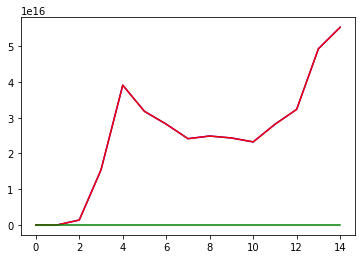

In [66]:
plt.plot(model.loss_history, 'b')
plt.plot(model.crit_history, 'r')
plt.plot(model.rec_history, 'g')

In [67]:
model.rec_history

[11.210070941878428,
 9.947353062742824,
 9.592307698889485,
 9.41530121529728,
 9.325038846836597,
 9.271190624799255,
 9.239495281518405,
 9.196597763653886,
 9.172239420827047,
 9.147905231122058,
 9.1334352870368,
 9.108716956494439,
 9.088599244782086,
 9.082480636284044,
 9.08455043178424]

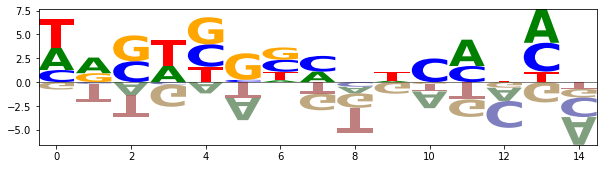

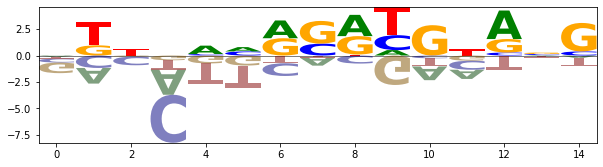

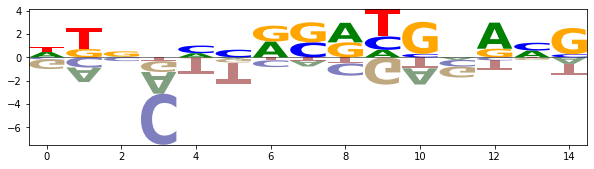

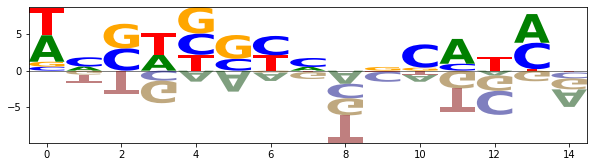

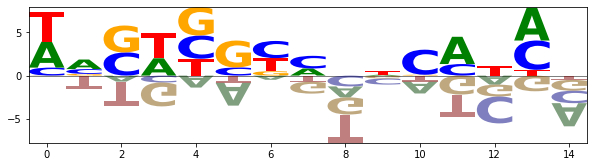

In [71]:
bm_pred = model.get_predicted_bm(torch.tensor(np.stack(x))[[0, 20, 50, 100, 150]])
bm_pred = bm_pred.cpu().detach().numpy()
for i in range(0, bm_pred.shape[0]):
    weights = bm_pred[i]
    weights = pd.DataFrame(weights)
    weights.index = "A", "C", "G", "T"
    crp_logo = logomaker.Logo(weights.T, shade_below=0.5, fade_below=0.5)

In [72]:
bm_pred = model.get_predicted_bm(torch.tensor(np.stack(x)))
bm_pred = bm_pred.cpu().detach().numpy()

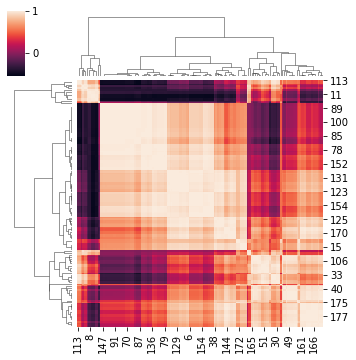

In [74]:
bm_df = bm_pred.reshape(-1, 60)
bm_df = pd.DataFrame(bm_df.T)
corr = bm_df.corr()
import seaborn as sns
sns.clustermap(corr, figsize=[5, 5])

# Smaller decoder (#1)

In [77]:
# Set up the dataset
df = pd.DataFrame(signal.T)
df['seq'] = seqs_dna
df.index = df['seq']
del df['seq']

dataset = mb.datasets.ResiduePBMDataset(df, x)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

# Set up the model
model = mb.models.ProteinDNABinding(0, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
reconstruction_crit = torch.nn.CrossEntropyLoss()

In [76]:
# +0.01*reconstruction criterion
mb.tl.train_network(model, train, device, optimizer, criterion, reconstruction_crit, num_epochs=15, exp_max=-1, log_each=1, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'torch.nn.modules.loss.MSELoss'> n_epochs 15 early_stopping -1
lr= 0.001, weight_decay= 0, dir weight= 0
Epoch:  2, Loss: nan , best epoch: 0 secs per epoch: 54.335 s
Epoch:  3, Loss: nan , best epoch: 0 secs per epoch: 40.974 s
Epoch:  4, Loss: nan , best epoch: 0 secs per epoch: 36.499 s
Epoch:  5, Loss: nan , best epoch: 0 secs per epoch: 34.335 s
Epoch:  6, Loss: nan , best epoch: 0 secs per epoch: 33.196 s
Epoch:  7, Loss: nan , best epoch: 0 secs per epoch: 32.296 s
Epoch:  8, Loss: nan , best epoch: 0 secs per epoch: 31.653 s
Epoch:  9, Loss: nan , best epoch: 0 secs per epoch: 31.184 s
Epoch: 10, Loss: nan , best epoch: 0 secs per epoch: 30.841 s


KeyboardInterrupt: 

# Larger Decoder (#2)

In [79]:
# Set up the dataset
df = pd.DataFrame(signal.T)
df['seq'] = seqs_dna
df.index = df['seq']
del df['seq']

dataset = mb.datasets.ResiduePBMDataset(df, x)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

# Set up the model
model = mb.models.ProteinDNABinding(0, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
reconstruction_crit = torch.nn.CrossEntropyLoss()

In [80]:
# +0.01*reconstruction criterion
mb.tl.train_network(model, train, device, optimizer, criterion, reconstruction_crit, num_epochs=15, exp_max=-1, log_each=1, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'torch.nn.modules.loss.MSELoss'> n_epochs 15 early_stopping -1
lr= 0.001, weight_decay= 0, dir weight= 0
Epoch:  2, Loss: 22030.063649 , best epoch: 0 secs per epoch: 83.268 s
Epoch:  3, Loss: 9488.808205 , best epoch: 1 secs per epoch: 62.374 s
Epoch:  4, Loss: 4465.563784 , best epoch: 2 secs per epoch: 55.720 s
Epoch:  5, Loss: 2388.127415 , best epoch: 3 secs per epoch: 52.334 s
Epoch:  6, Loss: 1260.949486 , best epoch: 4 secs per epoch: 50.190 s
Epoch:  7, Loss: 692.413093 , best epoch: 5 secs per epoch: 48.758 s
Epoch:  8, Loss: 404.368078 , best epoch: 6 secs per epoch: 47.747 s
Epoch:  9, Loss: 278.530287 , best epoch: 7 secs per epoch: 47.126 s
Epoch: 10, Loss: 227.308503 , best epoch: 8 secs per epoch: 46.555 s
Epoch: 11, Loss: 205.783328 , best epoch: 9 secs per epoch: 46.162 s
Epoch: 12, Loss: 126.117112 , best epoch: 10 secs per epoch: 45.808 s
Epoch: 13, Loss: 90.002017 , best epoch: 11 secs per epoch: 45.503 s


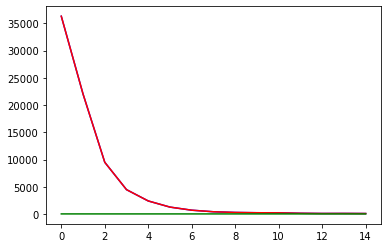

In [81]:
plt.plot(model.loss_history, 'b')
plt.plot(model.crit_history, 'r')
plt.plot(model.rec_history, 'g')

In [82]:
model.rec_history

[11.334093918652949,
 10.040010045707698,
 9.783957430649627,
 9.640193832940458,
 9.519946996468079,
 9.460775080556752,
 9.438759100342894,
 9.404111313699905,
 9.356488467805425,
 9.358884635201296,
 9.31383665305603,
 9.313684349690813,
 9.307221817164692,
 9.220992978916675,
 9.280459142091203]

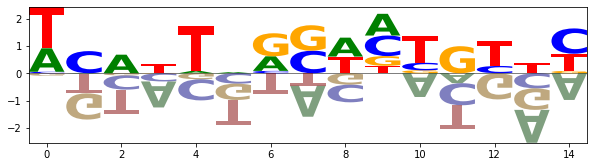

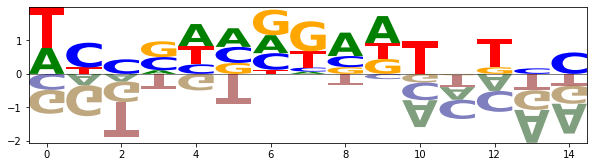

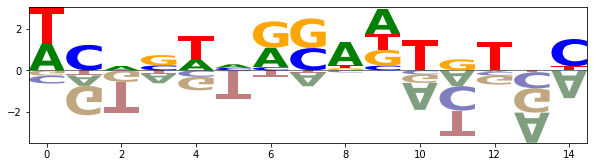

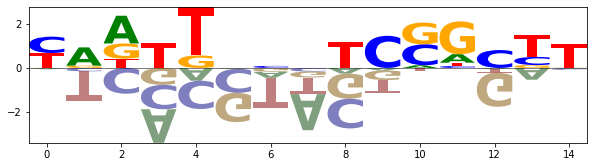

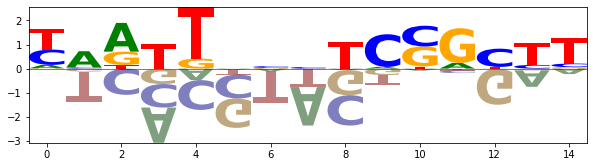

In [83]:
bm_pred = model.get_predicted_bm(torch.tensor(np.stack(x))[[0, 20, 50, 100, 150]])
bm_pred = bm_pred.cpu().detach().numpy()
for i in range(0, bm_pred.shape[0]):
    weights = bm_pred[i]
    weights = pd.DataFrame(weights)
    weights.index = "A", "C", "G", "T"
    crp_logo = logomaker.Logo(weights.T, shade_below=0.5, fade_below=0.5)

In [84]:
bm_pred = model.get_predicted_bm(torch.tensor(np.stack(x)))
bm_pred = bm_pred.cpu().detach().numpy()

/home/johanna/anaconda3/envs/multibind/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


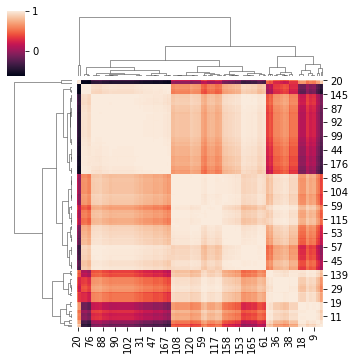

In [85]:
bm_df = bm_pred.reshape(-1, 60)
bm_df = pd.DataFrame(bm_df.T)
corr = bm_df.corr()
import seaborn as sns
sns.clustermap(corr, figsize=[5, 5])

# Even larger Decoder (#2)

In [6]:
# Set up the dataset
df = pd.DataFrame(signal.T)
df['seq'] = seqs_dna
df.index = df['seq']
del df['seq']

dataset = mb.datasets.ResiduePBMDataset(df, x)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

# Set up the model
model = mb.models.ProteinDNABinding(0, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
reconstruction_crit = torch.nn.CrossEntropyLoss()

In [7]:
# +0.01*reconstruction criterion
mb.tl.train_network(model, train, device, optimizer, criterion, reconstruction_crit, num_epochs=15, exp_max=-1, log_each=1, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'torch.nn.modules.loss.MSELoss'> n_epochs 15 early_stopping -1
lr= 0.001, weight_decay= 0, dir weight= 0
Epoch:  2, Loss: 37134.629335 , best epoch: 0 secs per epoch: 85.446 s
Epoch:  3, Loss: 18629.179237 , best epoch: 1 secs per epoch: 64.892 s
Epoch:  4, Loss: 11375.522405 , best epoch: 2 secs per epoch: 57.569 s
Epoch:  5, Loss: 11053.186436 , best epoch: 3 secs per epoch: 53.804 s
Epoch:  6, Loss: 11070.138475 , best epoch: 4 secs per epoch: 51.561 s
Epoch:  7, Loss: 12617.563262 , best epoch: 4 secs per epoch: 50.084 s
Epoch:  8, Loss: 17453.310902 , best epoch: 4 secs per epoch: 49.013 s
Epoch:  9, Loss: 31513.715364 , best epoch: 4 secs per epoch: 48.201 s
Epoch: 10, Loss: 33149.030339 , best epoch: 4 secs per epoch: 47.575 s
Epoch: 11, Loss: 85257.855426 , best epoch: 4 secs per epoch: 47.095 s
Epoch: 12, Loss: 136506.103188 , best epoch: 4 secs per epoch: 46.679 s
Epoch: 13, Loss: 395504.883090 , best epoch: 4 secs p

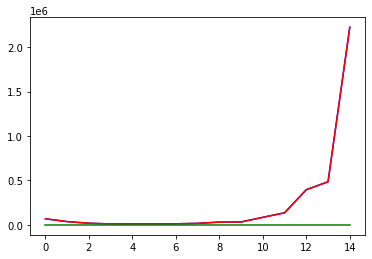

In [8]:
plt.plot(model.loss_history, 'b')
plt.plot(model.crit_history, 'r')
plt.plot(model.rec_history, 'g')

In [9]:
model.rec_history

[11.203930363905336,
 10.19155470164537,
 9.889288684260837,
 9.76555718491182,
 9.639352090233611,
 9.532486240269039,
 9.522483512362845,
 9.472080404856152,
 9.379999119630398,
 9.393133627605645,
 9.332730382402367,
 9.369300576956643,
 9.24714317637155,
 9.26380522623069,
 9.245050960954876]

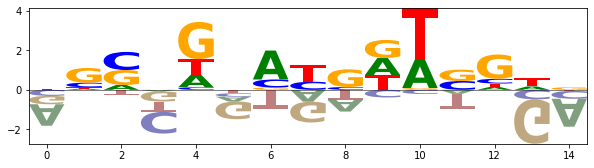

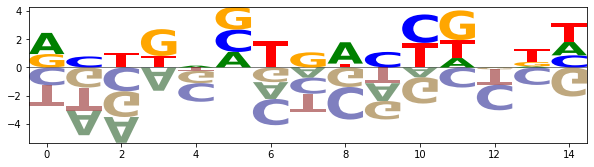

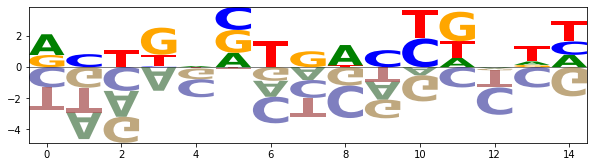

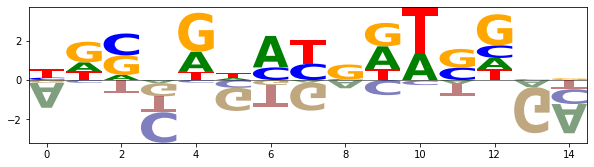

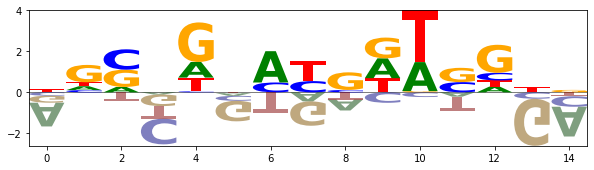

In [10]:
bm_pred = model.get_predicted_bm(torch.tensor(np.stack(x))[[0, 20, 50, 100, 150]])
bm_pred = bm_pred.cpu().detach().numpy()
for i in range(0, bm_pred.shape[0]):
    weights = bm_pred[i]
    weights = pd.DataFrame(weights)
    weights.index = "A", "C", "G", "T"
    crp_logo = logomaker.Logo(weights.T, shade_below=0.5, fade_below=0.5)

In [11]:
bm_pred = model.get_predicted_bm(torch.tensor(np.stack(x)))
bm_pred = bm_pred.cpu().detach().numpy()

/home/johanna/anaconda3/envs/multibind/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


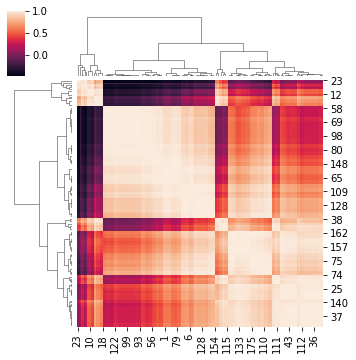

In [12]:
bm_df = bm_pred.reshape(-1, 60)
bm_df = pd.DataFrame(bm_df.T)
corr = bm_df.corr()
import seaborn as sns
sns.clustermap(corr, figsize=[5, 5])

# Decoder like #2

In [14]:
# Set up the dataset
df = pd.DataFrame(signal.T)
df['seq'] = seqs_dna
df.index = df['seq']
del df['seq']

dataset = mb.datasets.ResiduePBMDataset(df, x)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

# Set up the model
model = mb.models.ProteinDNABinding(0, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
reconstruction_crit = torch.nn.CrossEntropyLoss()

In [15]:
# +0.01*reconstruction criterion
mb.tl.train_network(model, train, device, optimizer, criterion, reconstruction_crit, num_epochs=25, exp_max=-1, log_each=1, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'torch.nn.modules.loss.MSELoss'> n_epochs 25 early_stopping -1
lr= 0.001, weight_decay= 0, dir weight= 0
Epoch:  2, Loss: 2523209.764535 , best epoch: 0 secs per epoch: 84.135 s
Epoch:  3, Loss: 4381306.946352 , best epoch: 0 secs per epoch: 62.813 s
Epoch:  4, Loss: 4649268.685602 , best epoch: 0 secs per epoch: 55.703 s
Epoch:  5, Loss: 5528451.334118 , best epoch: 0 secs per epoch: 52.148 s
Epoch:  6, Loss: 4302424.048380 , best epoch: 0 secs per epoch: 50.018 s
Epoch:  7, Loss: 3153136.156249 , best epoch: 0 secs per epoch: 48.605 s
Epoch:  8, Loss: 2124670.555529 , best epoch: 0 secs per epoch: 47.585 s
Epoch:  9, Loss: 1289222.534948 , best epoch: 0 secs per epoch: 46.862 s
Epoch: 10, Loss: 1583770.298963 , best epoch: 0 secs per epoch: 46.275 s
Epoch: 11, Loss: 1647114.360138 , best epoch: 0 secs per epoch: 45.807 s
Epoch: 12, Loss: 2084663.702800 , best epoch: 0 secs per epoch: 45.431 s
Epoch: 13, Loss: 2799960.965646 

In [16]:
# +0.01*reconstruction criterion
mb.tl.train_network(model, train, device, optimizer, criterion, reconstruction_crit, num_epochs=25, exp_max=-1, log_each=1, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'torch.nn.modules.loss.MSELoss'> n_epochs 25 early_stopping -1
lr= 0.001, weight_decay= 0, dir weight= 0
Epoch:  2, Loss: 140923.378369 , best epoch: 0 secs per epoch: 87.073 s
Epoch:  3, Loss: 139759.867726 , best epoch: 1 secs per epoch: 65.367 s
Epoch:  4, Loss: 108734.755577 , best epoch: 2 secs per epoch: 58.265 s
Epoch:  5, Loss: 89334.355762 , best epoch: 3 secs per epoch: 54.804 s
Epoch:  6, Loss: 67886.401797 , best epoch: 4 secs per epoch: 52.783 s
Epoch:  7, Loss: 58749.056938 , best epoch: 5 secs per epoch: 51.509 s
Epoch:  8, Loss: 61229.689625 , best epoch: 6 secs per epoch: 50.634 s
Epoch:  9, Loss: 68224.952328 , best epoch: 6 secs per epoch: 50.030 s
Epoch: 10, Loss: 94889.775894 , best epoch: 6 secs per epoch: 49.604 s
Epoch: 11, Loss: 131722.522455 , best epoch: 6 secs per epoch: 49.322 s
Epoch: 12, Loss: 176226.250310 , best epoch: 6 secs per epoch: 49.137 s
Epoch: 13, Loss: 259450.719244 , best epoch: 6 se

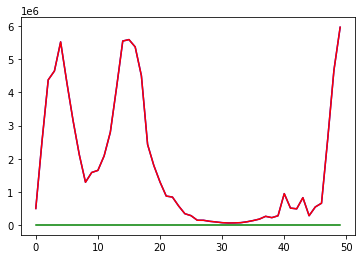

In [17]:
plt.plot(model.loss_history, 'b')
plt.plot(model.crit_history, 'r')
plt.plot(model.rec_history, 'g')

In [18]:
model.rec_history

[11.369070203247729,
 10.436165902873409,
 10.15122504066341,
 10.07367902998441,
 9.960703430203205,
 9.916498664812078,
 9.897440908968148,
 9.954714650991235,
 9.965623937863228,
 9.950529559236221,
 9.872447986040589,
 10.01925780394367,
 10.06437295945234,
 9.94621311889802,
 9.877706256211018,
 9.826687424753656,
 9.782639576838566,
 9.814058871512616,
 9.79741770239034,
 9.773624484612734,
 9.796676612431673,
 9.777628667572262,
 9.747272846597635,
 9.749598818490353,
 9.790486293246984,
 9.764081985808208,
 9.782799275807559,
 9.754997578393976,
 9.74394356750225,
 9.718835041558973,
 9.729815559195238,
 9.725458321341673,
 9.716346999195135,
 9.721144530860578,
 9.678813064295468,
 9.710410059826739,
 9.688488613350797,
 9.699727153023913,
 9.673674346901889,
 9.679476482931612,
 9.745244497879215,
 9.681942278151029,
 9.71184038755964,
 9.672078620093405,
 9.822304947096868,
 9.675078864409544,
 9.786444385646488,
 9.70281769679143,
 9.656193000305308,
 9.665564090034929]

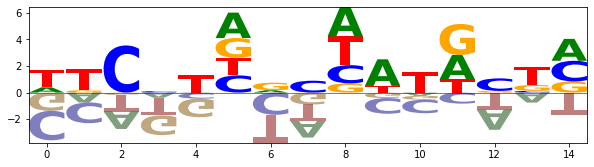

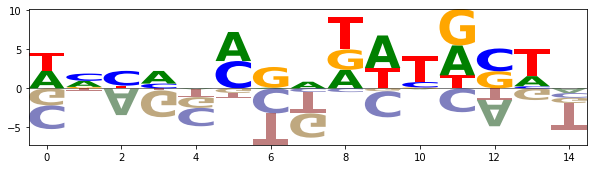

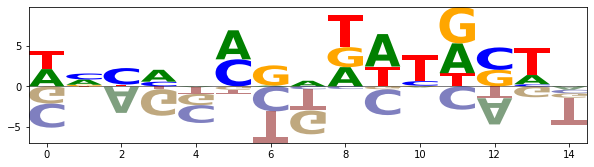

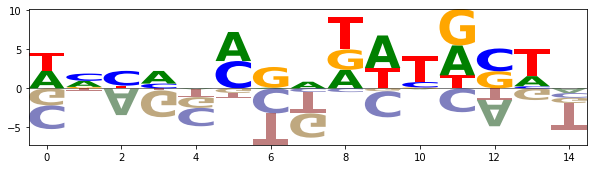

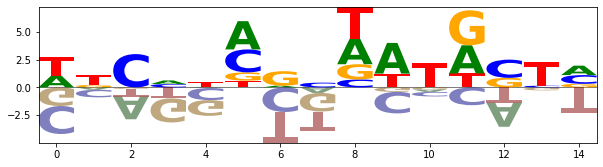

In [19]:
bm_pred = model.get_predicted_bm(torch.tensor(np.stack(x))[[0, 20, 50, 100, 150]])
bm_pred = bm_pred.cpu().detach().numpy()
for i in range(0, bm_pred.shape[0]):
    weights = bm_pred[i]
    weights = pd.DataFrame(weights)
    weights.index = "A", "C", "G", "T"
    crp_logo = logomaker.Logo(weights.T, shade_below=0.5, fade_below=0.5)

In [20]:
bm_pred = model.get_predicted_bm(torch.tensor(np.stack(x)))
bm_pred = bm_pred.cpu().detach().numpy()

/home/johanna/anaconda3/envs/multibind/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


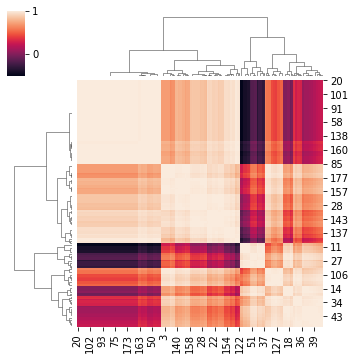

In [21]:
bm_df = bm_pred.reshape(-1, 60)
bm_df = pd.DataFrame(bm_df.T)
corr = bm_df.corr()
import seaborn as sns
sns.clustermap(corr, figsize=[5, 5])

# Decoder like #2 - Anaysis

In [22]:
# Set up the dataset
df = pd.DataFrame(signal.T)
df['seq'] = seqs_dna
df.index = df['seq']
del df['seq']

dataset = mb.datasets.ResiduePBMDataset(df, x)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

# Set up the model
model = mb.models.ProteinDNABinding(0, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
reconstruction_crit = torch.nn.CrossEntropyLoss()

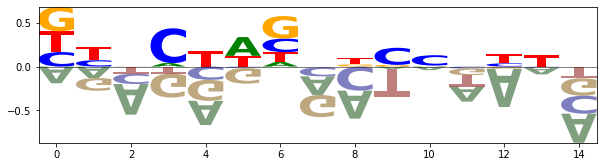

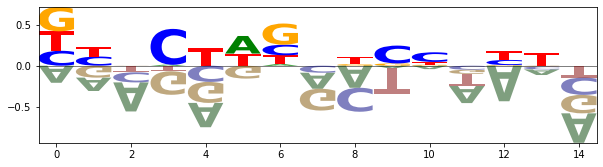

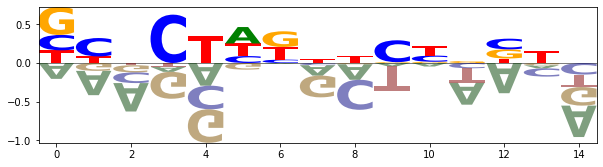

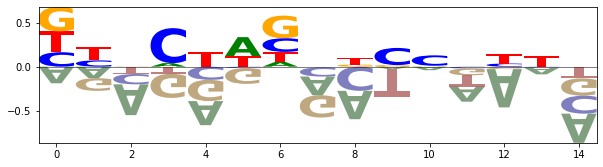

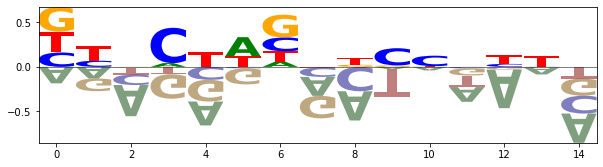

In [23]:
bm_pred = model.get_predicted_bm(torch.tensor(np.stack(x))[[0, 20, 50, 100, 150]])
bm_pred = bm_pred.cpu().detach().numpy()
for i in range(0, bm_pred.shape[0]):
    weights = bm_pred[i]
    weights = pd.DataFrame(weights)
    weights.index = "A", "C", "G", "T"
    crp_logo = logomaker.Logo(weights.T, shade_below=0.5, fade_below=0.5)

In [24]:
bm_pred = model.get_predicted_bm(torch.tensor(np.stack(x)))
bm_pred = bm_pred.cpu().detach().numpy()

/home/johanna/anaconda3/envs/multibind/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


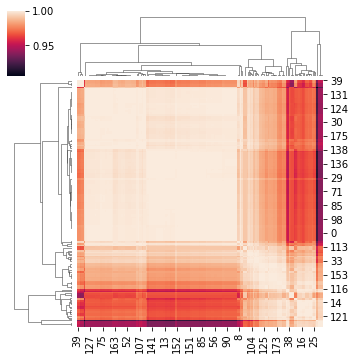

In [25]:
bm_df = bm_pred.reshape(-1, 60)
bm_df = pd.DataFrame(bm_df.T)
corr = bm_df.corr()
import seaborn as sns
sns.clustermap(corr, figsize=[5, 5])

In [27]:
train_test = tdata.DataLoader(dataset=dataset, batch_size=128)
all_seqs, all_targets, all_preds = mb.tl.test_network(model, train_test, device)

In [30]:
all_preds

array([[92.08451 ],
       [98.03809 ],
       [89.38496 ],
       ...,
       [90.901405],
       [94.64769 ],
       [96.95989 ]], dtype=float32)

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

import copy

model2 = copy.deepcopy(model)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0001)

In [32]:
# +0.01*reconstruction criterion
mb.tl.train_network(model, train, device, optimizer, criterion, reconstruction_crit, num_epochs=1, exp_max=-1, log_each=1, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'torch.nn.modules.loss.MSELoss'> n_epochs 1 early_stopping -1
lr= 0.0001, weight_decay= 0, dir weight= 0
total time: 42.921 s
secs per epoch: 42.921 s


In [33]:
# without reconstruction criterion
mb.tl.train_network(model2, train, device, optimizer2, criterion, reconstruction_crit, num_epochs=1, exp_max=-1, log_each=1, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'torch.nn.modules.loss.MSELoss'> n_epochs 1 early_stopping -1
lr= 0.0001, weight_decay= 0, dir weight= 0
total time: 43.116 s
secs per epoch: 43.116 s


In [34]:
model.loss_history

[50114.863504855435]

In [35]:
model2.loss_history

[5989.930155070543]

In [36]:
all_seqs_rec, all_targets_rec, all_preds_rec = mb.tl.test_network(model, train_test, device)

In [37]:
all_seqs_wo, all_targets_wo, all_preds_wo = mb.tl.test_network(model2, train_test, device)

In [40]:
all_preds_rec

array([[461.59927],
       [220.46716],
       [248.2702 ],
       ...,
       [239.88063],
       [251.54182],
       [293.49637]], dtype=float32)

In [39]:
all_preds_wo

array([[80.78519 ],
       [86.008224],
       [78.41688 ],
       ...,
       [79.74725 ],
       [83.033844],
       [85.062325]], dtype=float32)

# larger LSTM (#4)

In [44]:
# Set up the dataset
df = pd.DataFrame(signal.T)
df['seq'] = seqs_dna
df.index = df['seq']
del df['seq']

dataset = mb.datasets.ResiduePBMDataset(df, x)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

# Set up the model
model = mb.models.ProteinDNABinding(0, 1, hidden_size=5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
reconstruction_crit = torch.nn.CrossEntropyLoss()

In [45]:
# +0.01*reconstruction criterion
mb.tl.train_network(model, train, device, optimizer, criterion, reconstruction_crit, num_epochs=15, exp_max=-1, log_each=1, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'torch.nn.modules.loss.MSELoss'> n_epochs 15 early_stopping -1
lr= 0.001, weight_decay= 0, dir weight= 0
Epoch:  2, Loss: 85216.809506 , best epoch: 0 secs per epoch: 90.371 s
Epoch:  3, Loss: 274109.887202 , best epoch: 0 secs per epoch: 67.930 s
Epoch:  4, Loss: 526146.832504 , best epoch: 0 secs per epoch: 60.437 s
Epoch:  5, Loss: 999063.549585 , best epoch: 0 secs per epoch: 56.702 s
Epoch:  6, Loss: 1666627.791052 , best epoch: 0 secs per epoch: 54.503 s
Epoch:  7, Loss: 1904944.857039 , best epoch: 0 secs per epoch: 53.135 s
Epoch:  8, Loss: 2602832.626008 , best epoch: 0 secs per epoch: 52.085 s
Epoch:  9, Loss: 3080845.447639 , best epoch: 0 secs per epoch: 51.253 s
Epoch: 10, Loss: 2289644.901533 , best epoch: 0 secs per epoch: 50.484 s
Epoch: 11, Loss: 3027363.571044 , best epoch: 0 secs per epoch: 49.863 s
Epoch: 12, Loss: 3444889.411493 , best epoch: 0 secs per epoch: 49.366 s
Epoch: 13, Loss: 3537789.456208 , bes

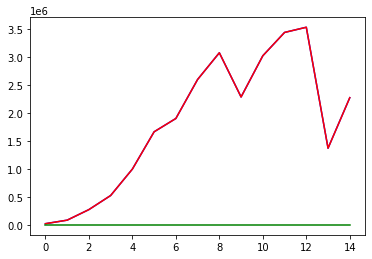

In [46]:
plt.plot(model.loss_history, 'b')
plt.plot(model.crit_history, 'r')
plt.plot(model.rec_history, 'g')

In [47]:
model.rec_history

[11.31522402225168,
 10.289239919074229,
 9.982073568595046,
 9.83981975662374,
 9.725430438537378,
 9.66409112394156,
 9.614167345761397,
 9.528248991921684,
 9.50148780597876,
 9.60026022995401,
 9.469013139380559,
 9.492665806406269,
 9.402882527996532,
 9.535626401153937,
 9.375537105809862]

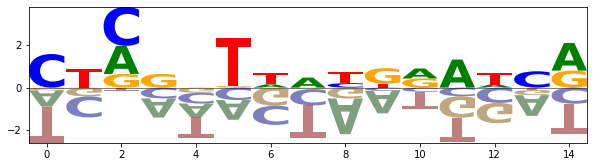

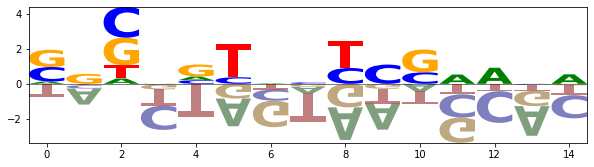

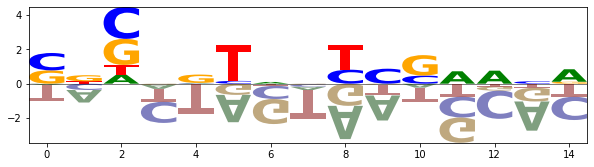

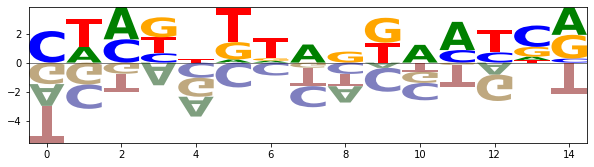

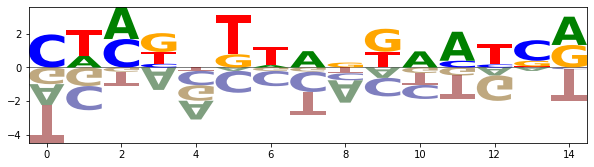

In [48]:
bm_pred = model.get_predicted_bm(torch.tensor(np.stack(x))[[0, 20, 50, 100, 150]])
bm_pred = bm_pred.cpu().detach().numpy()
for i in range(0, bm_pred.shape[0]):
    weights = bm_pred[i]
    weights = pd.DataFrame(weights)
    weights.index = "A", "C", "G", "T"
    crp_logo = logomaker.Logo(weights.T, shade_below=0.5, fade_below=0.5)

In [49]:
bm_pred = model.get_predicted_bm(torch.tensor(np.stack(x)))
bm_pred = bm_pred.cpu().detach().numpy()

/home/johanna/anaconda3/envs/multibind/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


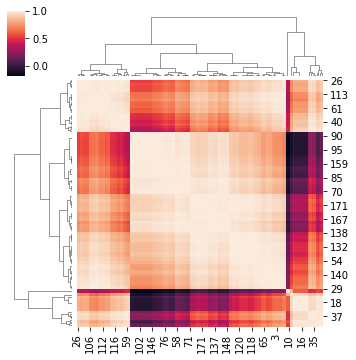

In [50]:
bm_df = bm_pred.reshape(-1, 60)
bm_df = pd.DataFrame(bm_df.T)
corr = bm_df.corr()
import seaborn as sns
sns.clustermap(corr, figsize=[5, 5])

In [53]:
model.multibind.log_activities[0]

Parameter containing:
tensor([[-8.2313]], requires_grad=True)

In [54]:
model.multibind.log_activities[1]

Parameter containing:
tensor([[-6.8199]], requires_grad=True)

In [56]:
model.multibind.log_etas[0]

tensor([0.], grad_fn=<SelectBackward0>)

# Decoder like #2